#### Importing the necessary libraries

In [1]:
# import libraries  
import numpy as np
import pandas as pd
import nltk
import re, random, os
import string, pprint
import matplotlib.pyplot as plt
import seaborn as sns

# spacy for basic preprocessing
import spacy

# gensim for LDA 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/opt/conda/lib/python3.7/site-packages/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """


In [2]:
df = pd.read_csv('/kaggle/input/amazon-product-reviews-dataset/7817_1.csv')
print(df.shape)
df.head()

(1597, 27)


,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,NaN,Cristina M,NaN,NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,NaN,Ricky,NaN,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,4.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,NaN,NaN,Tedd Gardiner,NaN,NaN,205 grams
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I bought one of the first Paperwhites and have...,Love / Hate relationship,NaN,NaN,Dougal,NaN,NaN,205 grams
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I have to say upfront - I don't like coroporat...,I LOVE IT,NaN,NaN,Miljan David Tanic,NaN,NaN,205 grams


In [3]:
# filter for product id = amazon echo
df = df[df['asins']=="B01BH83OOM"]
print(df.shape)
df.head()

(542, 27)


,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
852,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,"https://www.amazon.com/dp/B01BH83OOM,https://w...",IMPORTANT UPDATE (3/8/17): As you read my orig...,"The Echo's Little Sister Is AMAZING!! 3,",NaN,NaN,Deanokat,NaN,8.416670e+11,1.75 lbs
853,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,"https://www.amazon.com/dp/B01BH83OOM,https://w...",It was just a few weeks ago that I was bemoani...,Tap Alexa on the go!,NaN,NaN,Heather A,NaN,8.416670e+11,1.75 lbs
854,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,"https://www.amazon.com/dp/B01BH83OOM,https://w...",The Amazon Tap is a portable Bluetooth speaker...,Amazon Tap Review - Best Bluetooth Speaker in ...,NaN,NaN,Quentin Moore,NaN,8.416670e+11,1.75 lbs
855,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,http://reviews.bestbuy.com/3545/5097300/review...,Look at this product as a portable speaker fir...,Great for what it does,NaN,NaN,Casey,NaN,8.416670e+11,1.75 lbs
856,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,http://reviews.bestbuy.com/3545/5097300/review...,This Amazon tap is not only a great Bluetooth ...,"Awesome, smart little portable speaker",NaN,NaN,Tazman3582,NaN,8.416670e+11,1.75 lbs


In [4]:
# tokenize 
def sent_to_words(sentences, deacc=True): # deacc=True removes punctuations
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))  


# convert to list
data = df['reviews.text'].values.tolist()
data_words = list(sent_to_words(data))

# sample
print(data_words[3])

['look', 'at', 'this', 'product', 'as', 'portable', 'speaker', 'first', 'and', 'an', 'echo', 'replacement', 'second', 'the', 'big', 'reason', 'to', 'buy', 'this', 'over', 'standard', 'bluetooth', 'speakers', 'is', 'this', 'has', 'wifi', 'streaming', 'enabled', 'when', 'you', 'are', 'at', 'home', 'you', 'can', 'stream', 'music', 'with', 'ease', 'to', 'it', 'voice', 'recognition', 'is', 'top', 'notch', 'and', 'it', 'really', 'shines', 'when', 'using', 'it', 'with', 'other', 'smart', 'home', 'accessories', 'the', 'only', 'problem', 'is', 'having', 'to', 'tap', 'the', 'microphone', 'button', 'for', 'it', 'to', 'listen', 'to', 'your', 'voice', 'if', 'you', 'want', 'bigger', 'sound', 'and', 'always', 'listening', 'features', 'spend', 'the', 'extra', 'money', 'on', 'the', 'amazon', 'echo']


In [5]:
# create list of stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english') + list(string.punctuation)


In [6]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [7]:

# remove stop words
data_words_nostops = remove_stopwords(data_words)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[3])

['look', 'product', 'portable', 'speaker', 'replacement', 'second', 'big', 'reason', 'buy', 'standard', 'bluetooth', 'speaker', 'enable', 'home', 'stream', 'music', 'ease', 'voice', 'recognition', 'top', 'notch', 'really', 'shine', 'use', 'smart', 'home', 'accessory', 'problem', 'tap', 'microphone', 'button', 'listen', 'voice', 'want', 'big', 'sound', 'always', 'listen', 'feature', 'spend', 'extra', 'money', 'amazon', 'echo']


In [8]:
print(' '.join(data_words[3]), '\n')
print(' '.join(data_lemmatized[3]))

look at this product as portable speaker first and an echo replacement second the big reason to buy this over standard bluetooth speakers is this has wifi streaming enabled when you are at home you can stream music with ease to it voice recognition is top notch and it really shines when using it with other smart home accessories the only problem is having to tap the microphone button for it to listen to your voice if you want bigger sound and always listening features spend the extra money on the amazon echo 

look product portable speaker replacement second big reason buy standard bluetooth speaker enable home stream music ease voice recognition top notch really shine use smart home accessory problem tap microphone button listen voice want big sound always listen feature spend extra money amazon echo


### Creating Dictionary and Corpus

In [9]:
# create dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create corpus
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# sample
print(corpus[2])

[(3, 5), (12, 2), (15, 2), (16, 3), (19, 2), (23, 4), (27, 2), (30, 1), (34, 1), (47, 2), (50, 1), (55, 1), (59, 5), (68, 1), (80, 1), (83, 8), (86, 1), (89, 2), (94, 1), (95, 1), (96, 2), (98, 1), (99, 1), (108, 2), (112, 1), (116, 1), (120, 1), (129, 2), (132, 1), (135, 1), (142, 1), (143, 1), (144, 2), (145, 1), (146, 1), (147, 1), (148, 1), (149, 1), (150, 1), (151, 1), (152, 1), (153, 1), (154, 2), (155, 1), (156, 2), (157, 1), (158, 1), (159, 1), (160, 1), (161, 1), (162, 1), (163, 1), (164, 1), (165, 2), (166, 1), (167, 3), (168, 1), (169, 1), (170, 1), (171, 1), (172, 1), (173, 1), (174, 1), (175, 1), (176, 1), (177, 1), (178, 1), (179, 1), (180, 1), (181, 2), (182, 1), (183, 1), (184, 2), (185, 2), (186, 5), (187, 1), (188, 3), (189, 2), (190, 1), (191, 3), (192, 1), (193, 1), (194, 1), (195, 1), (196, 6), (197, 1), (198, 1), (199, 1), (200, 2), (201, 1), (202, 2), (203, 1), (204, 1), (205, 1), (206, 1), (207, 1), (208, 2), (209, 1), (210, 1), (211, 2), (212, 1)]


The (3, 7) above represents the fact that the word with id=3 appears 7 times in the second document (review), word id 12 appears twice and so on. The nested list below shows the frequencies of words in the first document.

### Building the Topic Model

In [10]:
# help(gensim.models.ldamodel.LdaModel)

In [11]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

Let's now print the topics found in the dataset.

In [12]:
# print the 10 topics
pprint.pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.030*"use" + 0.027*"say" + 0.023*"great" + 0.022*"get" + 0.021*"music" + '
  '0.020*"buy" + 0.018*"alexa" + 0.017*"enjoy" + 0.015*"find" + '
  '0.014*"device"'),
 (1,
  '0.050*"beat" + 0.035*"useful" + 0.023*"additional" + 0.019*"store" + '
  '0.015*"walk" + 0.012*"piece" + 0.007*"chagrin" + 0.007*"cut" + '
  '0.007*"around" + 0.007*"procrastinated"'),
 (2,
  '0.061*"easy" + 0.049*"use" + 0.039*"music" + 0.032*"question" + '
  '0.031*"great" + 0.027*"fun" + 0.025*"play" + 0.025*"ask" + 0.023*"really" + '
  '0.023*"tap"'),
 (3,
  '0.051*"know" + 0.047*"overall" + 0.021*"fire" + 0.019*"application" + '
  '0.018*"backyard" + 0.015*"podcast" + 0.014*"request" + 0.014*"continue" + '
  '0.014*"calendar" + 0.011*"playback"'),
 (4,
  '0.051*"love" + 0.033*"buy" + 0.032*"connect" + 0.025*"purchase" + '
  '0.023*"gift" + 0.019*"tap" + 0.016*"give" + 0.016*"charge" + '
  '0.015*"excellent" + 0.015*"stream"'),
 (5,
  '0.030*"price" + 0.029*"worth" + 0.018*"build" + 0.018*"hype" + 0.018*"p

In [13]:
# coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.43460377264509686


In [14]:
# visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.228497 -0.200627       1        1  28.832666
8     -0.228332 -0.075977       2        1  28.726705
4     -0.048773  0.181964       3        1  13.122670
0     -0.093168  0.078850       4        1  13.082180
2     -0.150594  0.163048       5        1  10.764119
6      0.160437 -0.049598       6        1   1.887242
3      0.159015 -0.021432       7        1   1.275890
5      0.152271 -0.036807       8        1   0.968740
7      0.132970 -0.022032       9        1   0.714216
1      0.144672 -0.017388      10        1   0.625573, topic_info=         Term        Freq       Total Category  logprob  loglift
27       echo  187.000000  187.000000  Default  30.0000  30.0000
167      good  137.000000  137.000000  Default  29.0000  29.0000
189   product   63.000000   63.000000  Default  28.0000  28.0000
396      easy   62.000000   62.000000  Default  27.0000  27.0000
13        buy   96.000000   96.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
1019    cheap    0.311078    1.951234  Topic10  -5.2009   3.2381
535      shop    0.030401    0.802372  Topic10  -7.5264   1.8012
526      rake    0.030401    0.802384  Topic10  -7.5264   1.8012
1142     side    0.030536    3.998493  Topic10  -7.5220   0.1995
451      tune    0.030501    3.628091  Topic10  -7.5232   0.2956

[463 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
281       2  0.990851        able
229       2  0.928144      access
144       1  0.433796    activate
144       4  0.542245    activate
606       1  0.964339  activation
...     ...       ...         ...
314       1  0.665415       worth
314       8  0.190118       worth
142       3  0.806291        year
142       4  0.100786        year
696       6  0.788089         yet

[477 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 9, 5, 1, 3, 7, 4, 6, 8, 2])

## Hyperparameter Tuning - Number of Topics , Alpha and Beta

tuning the hyperparameters - number of topics alpha and beta. The strategy typically used is to tune these parameters such that the coherence score is maximised.

In [18]:

def compute_coherence_values(dictionary, corpus, texts, num_topics_range, alpha_range,beta_range):
    
    coherence_values = []
    model_list = []
    for alpha in alpha_range:
        for num_topics in num_topics_range:
            for b in beta_range:
                
                
                lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=dictionary,
                                               num_topics=num_topics, 
                                               alpha=alpha,
                                               eta=b,
                                               per_word_topics=True)
                model_list.append(lda_model)
                coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
                coherence_values.append((alpha,b, num_topics, coherencemodel.get_coherence()))
        

    return model_list, coherence_values

In [16]:

num_topics_range = [6, 10, 15, 20]
alpha_range = [0.01, 0.1, 1]
beta_range=[0.01, 0.1, 1]
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        num_topics_range=num_topics_range, 
                                                        alpha_range=alpha_range,
                                                        beta_range=beta_range)

In [19]:
coherence_df = pd.DataFrame(coherence_values, columns=['alpha','beta', 'num_topics', 'coherence_value'])
coherence_df

,alpha,beta,num_topics,coherence_value
0,0.01,0.01,6,0.411554
1,0.01,0.10,6,0.457318
2,0.01,1.00,6,0.448647
3,0.01,0.01,10,0.412458
4,0.01,0.10,10,0.418524
5,0.01,1.00,10,0.447698
6,0.01,0.01,15,0.413910
7,0.01,0.10,15,0.416052
8,0.01,1.00,15,0.432012
9,0.01,0.01,20,0.417475


In [20]:
coherence_df.sort_values('coherence_value')

,alpha,beta,num_topics,coherence_value
0,0.01,0.01,6,0.411554
3,0.01,0.01,10,0.412458
6,0.01,0.01,15,0.413910
22,0.10,0.10,20,0.415570
18,0.10,0.01,15,0.415962
7,0.01,0.10,15,0.416052
19,0.10,0.10,15,0.416201
10,0.01,0.10,20,0.416207
9,0.01,0.01,20,0.417475
4,0.01,0.10,10,0.418524


In [30]:
alpha_subset = coherence_df[coherence_df['alpha']==1.00]
alpha_subset=alpha_subset[alpha_subset['beta']==0.01]

Text(0, 0.5, 'Coherence Value')

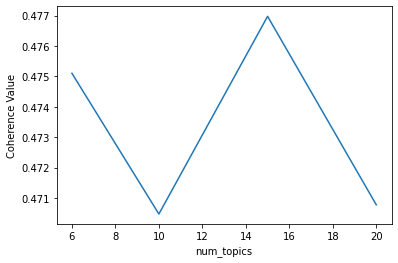

In [33]:
plt.plot(alpha_subset["num_topics"], alpha_subset["coherence_value"])
plt.xlabel('num_topics')
plt.ylabel('Coherence Value')

## Final model


In [38]:


Final_LDA_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                  id2word=id2word,
                                                  num_topics=15,
                                                  alpha=1,
                                                  eta=0.01,
                                                  per_word_topics=True)

In [39]:
# print the 15 topics
pprint.pprint(Final_LDA_model.print_topics())
doc_lda = Final_LDA_model[corpus]

[(0,
  '0.031*"tap" + 0.027*"sound" + 0.026*"great" + 0.025*"echo" + 0.021*"love" + '
  '0.020*"speaker" + 0.016*"use" + 0.015*"good" + 0.014*"music" + '
  '0.014*"well"'),
 (1,
  '0.033*"tap" + 0.029*"great" + 0.026*"music" + 0.023*"sound" + 0.023*"use" + '
  '0.016*"alexa" + 0.016*"love" + 0.016*"speaker" + 0.016*"good" + '
  '0.014*"work"'),
 (2,
  '0.028*"tap" + 0.027*"great" + 0.021*"use" + 0.019*"echo" + 0.019*"speaker" '
  '+ 0.019*"alexa" + 0.017*"love" + 0.016*"music" + 0.015*"good" + '
  '0.014*"buy"'),
 (3,
  '0.025*"sound" + 0.024*"speaker" + 0.023*"tap" + 0.021*"use" + 0.019*"buy" + '
  '0.019*"great" + 0.018*"love" + 0.017*"good" + 0.016*"echo" + 0.015*"music"'),
 (4,
  '0.034*"great" + 0.030*"tap" + 0.024*"sound" + 0.023*"use" + 0.020*"speaker" '
  '+ 0.017*"echo" + 0.016*"alexa" + 0.015*"love" + 0.014*"work" + '
  '0.013*"good"'),
 (5,
  '0.038*"great" + 0.027*"speaker" + 0.026*"tap" + 0.026*"use" + 0.025*"sound" '
  '+ 0.021*"alexa" + 0.019*"echo" + 0.016*"love" + 0.01

In [40]:
# coherence score
coherence_model_lda = CoherenceModel(model=Final_LDA_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.46979920881162174


In [41]:
# visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(Final_LDA_model, corpus, id2word)
vis

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.005223 -0.000323       1        1  10.150163
14     0.000375  0.000975       2        1   8.086120
6      0.005830  0.003482       3        1   7.939195
8      0.001566 -0.001506       4        1   7.030256
1      0.000453 -0.006357       5        1   6.993568
2      0.001685 -0.000072       6        1   6.752015
13     0.001157 -0.002971       7        1   6.641463
9      0.000319  0.000709       8        1   6.386404
0     -0.003141  0.003352       9        1   6.245771
11     0.000526  0.002112      10        1   6.198087
4     -0.000392  0.001577      11        1   6.189167
5     -0.001646 -0.001368      12        1   5.697328
10    -0.002733 -0.000766      13        1   5.387598
7     -0.005727  0.000306      14        1   5.328944
3     -0.003495  0.000847      15        1   4.973922, topic_info=          Term        Freq       Total Category  logprob  loglift
80       sound  197.000000  197.000000  Default  30.0000  30.0000
168      great  223.000000  223.000000  Default  29.0000  29.0000
196    speaker  189.000000  189.000000  Default  28.0000  28.0000
13         buy   99.000000   99.000000  Default  27.0000  27.0000
51        love  153.000000  153.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
335       work    4.130556  108.162278  Topic15  -4.6880  -0.2643
36         get    3.699784   93.707928  Topic15  -4.7982  -0.2309
152  bluetooth    2.509821   49.966472  Topic15  -5.1862   0.0098
184       play    2.961713   74.859711  Topic15  -5.0207  -0.2289
154     button    2.755474   68.436126  Topic15  -5.0929  -0.2113

[1137 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
281       1  0.075958  able
281       2  0.075958  able
281       3  0.075958  able
281       4  0.075958  able
281       5  0.037979  able
...     ...       ...   ...
142      15  0.078719  year
696       1  0.143479   yet
696       5  0.143479   yet
696       6  0.143479   yet
696      14  0.143479   yet

[2229 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 15, 7, 9, 2, 3, 14, 10, 1, 12, 5, 6, 11, 8, 4])

In [ ]:
#<<<------------------------------------------THE END---------------------------------------------->>